In [1]:
import pandas as pd
from pandas.plotting import parallel_coordinates
from math import radians, cos, sin, asin, sqrt, log  # Import required math functions
import os
import folium
from folium.plugins import HeatMap
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the dataset
raw_housing_data = pd.read_csv("data/NEWPrimaryDataset-MLS-RentalProperties.csv")

# Display basic information about the dataset
print(raw_housing_data.shape)
# raw_housing_data.info() # Get summary information about the columns and data types

# Display the first few rows of the dataset to inspect it
raw_housing_data.head()

# raw_housing_data.columns

(1750, 77)


,List Number,Agency Phone,Listing Agent,Co-Listing Agent,Property Type,Card Format,Book Section,Property Sub Type,Listing Contract Date,Back on Market Date,...,Carport Spaces,Non-Representative Compensation,Entry Level,Accessibility Features YN,Unit Type,Comp Sale YN,Price Change Timestamp,Days on Market,Rooms,Features
0,NotAScam123,Agency_Phone_Index_656,Listing_Agent_Index_999,NaN,Rental,Residential Lease,Single Family Residence,SF,9/22/24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,Ugrent Sale
1,gAAAAABm9wKyQ9Jkf67wT775NlUCIiB2uBl4wESoZ5GvSi...,Agency_Phone_Index_656,Listing_Agent_Index_974,NaN,Rental,Residential Lease,Townhouse,TH,3/2/24,NaN,...,NaN,0.0,1.0,N,NaN,N,NaN,137,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...
2,gAAAAABm9wKysBww5tTVmO-0CpaE-LagSeR4KNGjc7knBz...,Agency_Phone_Index_657,Listing_Agent_Index_975,NaN,Rental,Residential Lease,Quadruplex,QU,6/3/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,9/22/24 1:37,65,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...
3,gAAAAABm9wKyuy2g6q3NVvgVVN2exdWKr-5NmAsg3RNetA...,Agency_Phone_Index_658,Listing_Agent_Index_976,NaN,Rental,Residential Lease,Single Family Residence,SF,6/21/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,NaN,15,NaN,Additional Lease Terms|Other|Yes;Deposits and ...
4,gAAAAABm9wKybWr-f_0vG4kOlej1Gw_MwtKb3AMZPFNdte...,Agency_Phone_Index_659,Listing_Agent_Index_977,NaN,Rental,Residential Lease,Single Family Residence,SF,6/8/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,NaN,72,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...


# Selecting Relevant and/or Numerical Columns
In this cell, we focus on selecting specific columns from the dataset for further analysis:

<!-- **Relevant Columns:** We define the relevant_columns list, which contains a broader set of columns, including both numerical and categorical data that are deemed important for our analysis. -->

**Numerical Columns**: From the relevant_columns, we further narrow down the dataset by selecting only the numerical columns for ease of analysis, such as price, number of bedrooms, bathrooms, area size, etc. These are stored in the numerical_columns list.

**Dropping Irrelevant Columns**: Using the numerical_columns, we create a new DataFrame, cleaned_housing_data, which contains only the relevant numerical columns. This step simplifies the dataset and prepares it for further processing, like model training or statistical analysis.

In [3]:
# Select only the numerical columns for analysis
numerical_columns = [
    'List Number','List Price', 'Bedrooms Total', 'Bathrooms Total', 'Living Area', 'MLS Area Major', 'Year Built', 'Lot Size Acres', 'Days on Market', 'Non-Representative Compensation',
    'Stories Total', 'Stories', 'Bathrooms Full', 'Bathrooms Half', 'Garage Spaces', 'Original List Price', 'Latitude', 'Longitude'
]

# Create a new DataFrame with only the selected numerical columns
numerical_housing_data = raw_housing_data[numerical_columns]

# Cleaning the Dataset
In this cell, we perform data cleaning operations to ensure that the dataset is suitable for further analysis

In [4]:
# Drop rows with any missing values
numerical_housing_data = numerical_housing_data.dropna()

# Check for duplicate columns and remove them
numerical_housing_data = numerical_housing_data.loc[:, ~numerical_housing_data.columns.duplicated()]

# Output the dimensions of the cleaned dataset and preview its structure
print(numerical_housing_data.shape)
numerical_housing_data.info()
numerical_housing_data.head()



(340, 18)
<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, 25 to 1746
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   List Number                      340 non-null    object 
 1   List Price                       340 non-null    int64  
 2   Bedrooms Total                   340 non-null    int64  
 3   Bathrooms Total                  340 non-null    int64  
 4   Living Area                      340 non-null    float64
 5   MLS Area Major                   340 non-null    int64  
 6   Year Built                       340 non-null    int64  
 7   Lot Size Acres                   340 non-null    float64
 8   Days on Market                   340 non-null    int64  
 9   Non-Representative Compensation  340 non-null    float64
 10  Stories Total                    340 non-null    float64
 11  Stories                          340 non-null    float64
 12  Bathrooms Full 

,List Number,List Price,Bedrooms Total,Bathrooms Total,Living Area,MLS Area Major,Year Built,Lot Size Acres,Days on Market,Non-Representative Compensation,Stories Total,Stories,Bathrooms Full,Bathrooms Half,Garage Spaces,Original List Price,Latitude,Longitude
25,gAAAAABm9wKy8iEF2iPj4yUG9W9aJzlue0ha1rOr4yH2hV...,1695,2,2,1230.0,26,2008,0.01,55,10.0,2.0,2.0,2,0.0,1.0,1725,30.284262,-81.454856
27,gAAAAABm9wKyZy5yVqVfOab8ncZ2KX9fPYOjfO9KuSTwOh...,2700,5,2,2498.0,14,1996,0.46,43,0.0,2.0,2.0,2,0.0,2.0,2900,30.156717,-81.629576
38,gAAAAABm9wKyO0FKSTfQtXpJt527HRb4FRUbo6r7zsshdH...,2500,5,2,1990.0,135,1980,0.27,53,100.0,1.0,1.0,2,0.0,2.0,2600,30.160414,-81.744717
40,gAAAAABm9wKyzMbRTpX1vRA4eWcmaYrxsjpy9YlV1jQyBf...,4425,3,3,2442.0,43,2012,0.10,23,1.0,2.0,2.0,2,1.0,2.0,4425,30.341041,-81.461648
41,gAAAAABm9wKyN72eWI3levdaCpsUo_0YQoDg888YszAwJH...,4500,3,2,1426.0,212,1979,0.14,21,1.0,2.0,2.0,2,0.0,1.0,4500,30.266153,-81.398813


# Creating Engineered Features
In this cell, we create new price ratio features using the data from the numerical_housing_data DataFrame. Instead of relying solely on the list price, these ratios offer more accurate and meaningful measures of the property’s value by adjusting for specific characteristics like the number of bedrooms, bathrooms, and square footage.

In [5]:
# Add engineered price metrics to the main DataFrame
numerical_housing_data['Price per Bedroom'] = numerical_housing_data['List Price'] / numerical_housing_data['Bedrooms Total']
numerical_housing_data['Price per Full Bathroom'] = numerical_housing_data['List Price'] / numerical_housing_data['Bathrooms Full']
numerical_housing_data['Price per Total Bathroom'] = numerical_housing_data['List Price'] / numerical_housing_data['Bathrooms Total']
numerical_housing_data['Price per Story'] = numerical_housing_data['List Price'] / numerical_housing_data['Stories']
numerical_housing_data['Price per Garage Space'] = numerical_housing_data['List Price'] / numerical_housing_data['Garage Spaces']
numerical_housing_data['Price per Living Area'] = numerical_housing_data['List Price'] / numerical_housing_data['Living Area']
numerical_housing_data['Price per Lot Size Acre'] = numerical_housing_data['List Price'] / numerical_housing_data['Lot Size Acres']
numerical_housing_data['Price per Year Built'] = numerical_housing_data['List Price'] / numerical_housing_data['Year Built']

# Handle NaN and infinity values for consistency in the main DataFrame
columns_to_fix = ['Price per Bedroom', 'Price per Full Bathroom', 'Price per Total Bathroom', 
                  'Price per Story', 'Price per Garage Space', 'Price per Living Area', 
                  'Price per Lot Size Acre', 'Price per Year Built']

# Fix NaN and infinite values
for col in columns_to_fix:
    numerical_housing_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    numerical_housing_data[col].fillna(numerical_housing_data[col].median(), inplace=True)

# Now, all price metrics are stored within numerical_housing_data, and we can proceed with other features or flags

/var/folders/t5/ksv476hn4cq52bmfy8685cnh0000gn/T/ipykernel_50118/3227815537.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  numerical_housing_data[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/t5/ksv476hn4cq52bmfy8685cnh0000gn/T/ipykernel_50118/3227815537.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In the context of detecting fraudulent or nefarious listings, the `Under_30_Days_Flag` provides important insights into the listing behavior:
1. Rapid Turnover Can Indicate Fraud:
    Listings that are on the market for 30 days or less and then disappear could be suspicious. Scammers may list fake properties, get quick responses, and remove the listing once they've attracted victims. A high turnover rate may suggest that the listing is either underpriced to lure in victims or that the listing is fake and meant to disappear quickly.
2. Uncommon Market Behavior:
    In most real estate markets, properties tend to stay listed for more than 30 days unless they are highly desirable or misrepresented. Listings with a flag of 1 (30 days or less) can be used as a potential red flag for deeper analysis, especially when combined with other indicators like price anomalies or inconsistent agent information.

3. Behavioral Clustering:
    By using the Under_30_Days_Flag, we can cluster or categorize properties based on their time on the market. If a cluster of properties flagged as "Under 30 Days" shares other suspicious characteristics (e.g., odd pricing, proximity to multiple points of interest), it strengthens the likelihood that the listings are fraudulent.

In [6]:
# Add the Under_30_Days_Flag (1 = 30 days or less, 0 = more than 30 days)
numerical_housing_data['Under_30_Days_Flag'] = numerical_housing_data['Days on Market'].apply(lambda x: 1 if x <= 30 else 0)

# Verify the first few rows of the updated dataset
print(numerical_housing_data[['Days on Market', 'Under_30_Days_Flag']].head())

    Days on Market  Under_30_Days_Flag
25              55                   0
27              43                   0
38              53                   0
40              23                   1
41              21                   1


### Suspiciousness Score Based on Proximity to Important Locations
In this cell, we calculate a suspicion score for each listing based on its proximity to important locations such as universities and military bases. Listings close to high-traffic or important areas might be more likely to exhibit suspicious behavior, such as underpricing or quick turnover, which could indicate fraudulent activity.

1. Important Locations:
A list of important locations (e.g., universities, military bases) is used to compute suspiciousness scores. Each location is assigned a weight based on its importance, such as the size of the population it serves.
2. Suspiciousness Calculation:
We use the Haversine formula to calculate the distance between the listing and important locations. A suspiciousness score is calculated using a weighted logarithmic distance function, where listings closer to high-weight locations have higher suspiciousness scores.
3. Filtering and Visualization:
Listings without latitude or longitude are filtered out. We then visualize the suspiciousness scores on a heatmap using Folium, with the intensity of the color indicating higher levels of suspicion.
4. Heatmap:
The heatmap is centered around Duval County, and it is saved as an HTML file for further inspection.

In [7]:
# List of important locations with weights
important_coordinates = [
    {"name": "University of North Florida", "latitude": 30.2715, "longitude": -81.5094, "weight": 0.7727},  # Jacksonville, Duval County
    {"name": "Flagler College", "latitude": 29.8947, "longitude": -81.3145, "weight": 0.1182},  # St. Augustine, St. Johns County
    {"name": "St. Johns River State College", "latitude": 29.6486, "longitude": -81.6417, "weight": 0.2955},  # Palatka, Putnam County
    {"name": "Edward Waters University", "latitude": 30.3422, "longitude": -81.6794, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Concorde Career Institute", "latitude": 30.3374, "longitude": -81.5546, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "First Coast Technical College", "latitude": 29.8922, "longitude": -81.3305, "weight": 0.0182},  # St. Augustine, St. Johns County
    {"name": "Jacksonville University", "latitude": 30.3532, "longitude": -81.6068, "weight": 0.2045},  # Jacksonville, Duval County
    {"name": "Jones Technical Institute", "latitude": 30.2449, "longitude": -81.5322, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Tulsa Welding School", "latitude": 30.3385, "longitude": -81.5637, "weight": 0.0136},  # Jacksonville, Duval County
    {"name": "Chamberlain University-Florida", "latitude": 30.2598, "longitude": -81.5904, "weight": 0.0409},  # Jacksonville, Duval County
    {"name": "Fortis College-Orange Park", "latitude": 30.1785, "longitude": -81.7079, "weight": 0.0318},  # Orange Park, Clay County
    {"name": "Florida State College at Jacksonville", "latitude": 30.3322, "longitude": -81.6557, "weight": 1.0000},  # Jacksonville, Duval County
    {"name": "Trinity Baptist College", "latitude": 30.2395, "longitude": -81.7802, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "Keiser University", "latitude": 30.3326, "longitude": -81.6562, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Heritage Institute", "latitude": 30.2033, "longitude": -81.5837, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Embry-Riddle Aeronautical University", "latitude": 29.1880, "longitude": -81.0479, "weight": 0.4091},  # Daytona Beach, Volusia County
    {"name": "Naval Air Station Jacksonville", "latitude": 30.2358, "longitude": -81.6800, "weight": 0.9545},  # Jacksonville, Duval County
    {"name": "Naval Station Mayport", "latitude": 30.3915, "longitude": -81.4245, "weight": 0.5455},  # Jacksonville, Duval County
    {"name": "Camp Blanding Joint Training Center", "latitude": 29.9693, "longitude": -81.9840, "weight": 0.6818},  # Clay County
    {"name": "Marine Corps Blount Island Command", "latitude": 30.4111, "longitude": -81.5059, "weight": 0.1364},  # Jacksonville, Duval County
]

# Haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c  # Radius of Earth in kilometers
    return km

# Function to calculate suspicion score based on proximity to important locations
def calculate_weighted_suspiciousness(row, important_locations, max_distance=50, scaling_factor=1):
    listing_lat = row['Latitude']
    listing_lon = row['Longitude']
    
    total_suspiciousness = 0
    baseline_suspiciousness = 0.05  # To account for listings far from important locations
    
    for location in important_locations:
        dist = haversine(listing_lat, listing_lon, location['latitude'], location['longitude'])
        
        # Only compute suspiciousness for distances within the max limit
        if dist <= max_distance:
            location_suspiciousness = location['weight'] * (1 / (log(dist + 1) + scaling_factor))
            total_suspiciousness += location_suspiciousness
    
    # Add baseline score if total suspiciousness is very low
    total_suspiciousness = max(baseline_suspiciousness, total_suspiciousness)
    
    return total_suspiciousness

# Apply the suspicion calculation to each listing in the dataset
numerical_housing_data['Distance Suspiciousness'] = numerical_housing_data.apply(lambda row: calculate_weighted_suspiciousness(row, important_coordinates), axis=1)

# Create a map centered around Duval County
m = folium.Map(location=[30.3322, -81.6557], zoom_start=10)

# Create a list of coordinates and weights (suspicion scores) for the heatmap
heatmap_data = [[row['Latitude'], row['Longitude'], row['Distance Suspiciousness']] for index, row in numerical_housing_data.iterrows()]

# Add the heatmap layer with suspicion scores
HeatMap(heatmap_data, max_value=1, radius=15, blur=10).add_to(m)

# Save the map to an HTML file
# m.save('suspicion_score_heatmap.html')


In [ ]:
# TO - DO: Improve the function, make the functions more dynamic. i.e, calculate weights better 

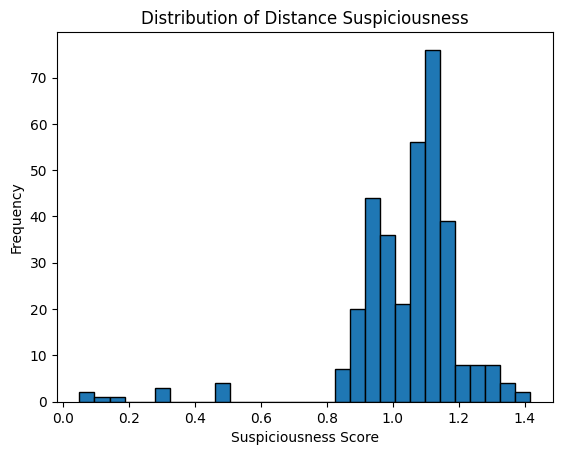

In [8]:
plt.hist(numerical_housing_data['Distance Suspiciousness'], bins=30, edgecolor='black')
# Add titles and labels
plt.title('Distribution of Distance Suspiciousness')
plt.xlabel('Suspiciousness Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

### Detecting Suspicious Phone Numbers Based on Multiple Agent Associations
In this cell, we aim to detect suspicious phone numbers by identifying numbers that are associated with more than one unique listing agent. These suspicious phone numbers could indicate potential fraud, such as a single person or entity listing properties under multiple names to create the illusion of different agents.

In [9]:
# Step 1: Merge based on 'List Number' as the unique identifier
# Drop 'Listing Agent' and 'Agency Phone' in numerical_housing_data if they exist
numerical_housing_data = numerical_housing_data.drop(columns=['Listing Agent', 'Agency Phone'], errors='ignore')

# Step 1: Merge based on 'List Number' as the unique identifier
numerical_housing_data = numerical_housing_data.merge(
    raw_housing_data[['List Number', 'Listing Agent', 'Agency Phone']], 
    on='List Number', 
    how='left'
)


# Step 2: Group by 'Agency Phone' and aggregate the unique 'Listing Agent' values
duplicates = numerical_housing_data.groupby('Agency Phone')['Listing Agent'].nunique()

# Step 3: Filter for phone numbers that are associated with more than one unique agent name
suspicious_numbers = duplicates[duplicates > 1]

# Step 4: Flag listings that contain suspicious phone numbers
def flag_suspicious_phone(row):
    if row['Agency Phone'] in suspicious_numbers.index:
        return 1  # Flag as suspicious
    return 0  # Not suspicious

# Step 5: Apply the function to the raw_housing_data DataFrame
numerical_housing_data['is_phone_suspicious'] = numerical_housing_data.apply(flag_suspicious_phone, axis=1)

# Step 6: Display flagged listings
suspicious_phone_listings = numerical_housing_data[numerical_housing_data['is_phone_suspicious'] == 1]
print(suspicious_phone_listings)


                                           List Number  List Price  \
0    gAAAAABm9wKy8iEF2iPj4yUG9W9aJzlue0ha1rOr4yH2hV...        1695   
1    gAAAAABm9wKyZy5yVqVfOab8ncZ2KX9fPYOjfO9KuSTwOh...        2700   
2    gAAAAABm9wKyO0FKSTfQtXpJt527HRb4FRUbo6r7zsshdH...        2500   
3    gAAAAABm9wKyzMbRTpX1vRA4eWcmaYrxsjpy9YlV1jQyBf...        4425   
4    gAAAAABm9wKyN72eWI3levdaCpsUo_0YQoDg888YszAwJH...        4500   
..                                                 ...         ...   
327  gAAAAABm9wKy4l8o4r_XnMbd9SBNRZZoxejrP1PVND5ugM...        4050   
331  gAAAAABm9wKyZ7oyYD1xjxFZxxKXEh4OlVsFjgug-4QJqk...        3200   
334  gAAAAABm9wKy3EKc9CTpbCMDFCnW0hOmDro6Bu-gIDu_4X...        3400   
338  gAAAAABm9wKyKdxHsPqZYBHf9lHdjPWGImYwIRwLd3NEmP...        1620   
339  gAAAAABm9wKy_Kh_pxh7FOqfUuzhjUAQuSn4K3cfqHvILr...        3550   

     Bedrooms Total  Bathrooms Total  Living Area  MLS Area Major  Year Built  \
0                 2                2       1230.0              26        2008 

### Flagging Suspicious Listings Based on Suspicious Words
This section describes how we detect suspicious listings by checking for the presence of specific words or phrases commonly associated with fraudulent listings. We flag listings that contain any of these suspicious words and merge the flag into the numerical_housing_data DataFrame.

In [10]:
suspicious_words = [
    'urgent', 'alert', 'wire transfer', 'guaranteed', 'free',
    'cash only', 'as seen on', 'limited time', 'don’t miss out',
    'risk-free', 'act now', 'exclusive', 'once in a lifetime',
   'contact now', 'no credit check', 'easy approval','Foreclosure',
     "no deposit required", "move-in specials", "free month rent", "lease takeover", "rent-to-own", 
    "pre-approval needed", "urgent rental", "hurry, limited time offer", "cash only, no checks", 
    "first month free", "no background check", "instant approval", "no credit history needed", 
    "temporary housing", "assume the lease", "short-term rental", "virtual tour only", 
    "sublease opportunity", "guaranteed approval", "utilities included", "all bills paid", 
   "no application fee", "get approved today", "house sitting", "unbelievably low rent", 
    "no lease required", "instant income", "non-refundable deposit", "limited properties available", 
    "you won't believe the price", "exclusive listings", "flexible terms", "unforeseen circumstances", 
    "background check waived", "contact immediately", "first come, first served", "urgent need to rent", 
    "newly renovated", "don’t get left out", "act fast before it’s gone", "scam-free guarantee", 
    "friendly landlord", "best value rental", "quick approval process", "no hassle, no fees", 
    "all-inclusive rental", "hidden gem", "affordable living", "ideal for students", 
    "rent today, move in tomorrow"
]

# Step 1: Create a regex pattern from the list of suspicious words
suspicious_words_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in suspicious_words) + r')\b'

# Step 2: Ensure NaN values in 'Features' are treated as empty strings
raw_housing_data['Features'] = raw_housing_data['Features'].fillna('').str.lower()

# Step 3: Create a temporary DataFrame with 'List Number' and 'is_suspicious' flag
temp_suspicious_data = raw_housing_data[['List Number']].copy()
temp_suspicious_data['contains_suspicious_diction'] = np.where(raw_housing_data['Features'].str.contains(suspicious_words_pattern, regex=True), 1, 0)

# Display the temp_suspicious_data to verify
print(temp_suspicious_data.head())

# Step 4: Merge the suspicious flag into numerical_housing_data
numerical_housing_data = numerical_housing_data.merge(temp_suspicious_data, on='List Number', how='left')

# Step 5: Display the merged numerical_housing_data
print(numerical_housing_data.head())


                                         List Number  \
0                                        NotAScam123   
1  gAAAAABm9wKyQ9Jkf67wT775NlUCIiB2uBl4wESoZ5GvSi...   
2  gAAAAABm9wKysBww5tTVmO-0CpaE-LagSeR4KNGjc7knBz...   
3  gAAAAABm9wKyuy2g6q3NVvgVVN2exdWKr-5NmAsg3RNetA...   
4  gAAAAABm9wKybWr-f_0vG4kOlej1Gw_MwtKb3AMZPFNdte...   

   contains_suspicious_diction  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  
                                         List Number  List Price  \
0  gAAAAABm9wKy8iEF2iPj4yUG9W9aJzlue0ha1rOr4yH2hV...        1695   
1  gAAAAABm9wKyZy5yVqVfOab8ncZ2KX9fPYOjfO9KuSTwOh...        2700   
2  gAAAAABm9wKyO0FKSTfQtXpJt527HRb4FRUbo6r7zsshdH...        2500   
3  gAAAAABm9wKyzMbRTpX1vRA4eWcmaYrxsjpy9YlV1jQyBf...        4425   
4  gAAAAABm9wKyN72eWI3levdaCpsUo_0YQoDg888YszAwJH...        4500   

   Bedrooms Total  Bathrooms Total  Living Area  MLS Are

# Dropping Unnecessary Columns and Saving the Final Dataset
In this cell, we prepare the final dataset for analysis or model training by dropping unnecessary columns and saving the resulting DataFrame as a CSV file.

Columns to Drop:
We identify a set of columns (columns_to_drop) that are no longer needed for further analysis. These include columns such as List Number, List Price, Bedrooms Total, Agency Phone, Listing Agent created during merging operations.



In [11]:
numerical_housing_data.columns

Index(['List Number', 'List Price', 'Bedrooms Total', 'Bathrooms Total',
       'Living Area', 'MLS Area Major', 'Year Built', 'Lot Size Acres',
       'Days on Market', 'Non-Representative Compensation', 'Stories Total',
       'Stories', 'Bathrooms Full', 'Bathrooms Half', 'Garage Spaces',
       'Original List Price', 'Latitude', 'Longitude', 'Price per Bedroom',
       'Price per Full Bathroom', 'Price per Total Bathroom',
       'Price per Story', 'Price per Garage Space', 'Price per Living Area',
       'Price per Lot Size Acre', 'Price per Year Built', 'Under_30_Days_Flag',
       'Distance Suspiciousness', 'Listing Agent', 'Agency Phone',
       'is_phone_suspicious', 'contains_suspicious_diction'],
      dtype='object')

In [12]:

columns_to_drop = ['List Price', 'Bedrooms Total', 'Bathrooms Total', 'Living Area',
                   'MLS Area Major', 'Year Built', 'Lot Size Acres', 'Days on Market',
                   'Non-Representative Compensation', 'Stories Total', 'Stories',
                   'Bathrooms Full', 'Bathrooms Half', 'Garage Spaces',
                   'Original List Price', 'Latitude', 'Longitude', 'Agency Phone', 'Listing Agent']

# Drop the columns
final_df = numerical_housing_data.drop(columns=columns_to_drop)

print(final_df.columns)



Index(['List Number', 'Price per Bedroom', 'Price per Full Bathroom',
       'Price per Total Bathroom', 'Price per Story', 'Price per Garage Space',
       'Price per Living Area', 'Price per Lot Size Acre',
       'Price per Year Built', 'Under_30_Days_Flag', 'Distance Suspiciousness',
       'is_phone_suspicious', 'contains_suspicious_diction'],
      dtype='object')


# Adding Our Own Scam Row to the DataFrame
In this section, we programmatically add a new row to the final_df DataFrame, representing a listing that is highly likely to be flagged as suspicious. The new row contains anomalous values for various features, which could trigger the anomaly detection system.

In [13]:

# Step 1: Define multiple scam rows
scam_rows = [
    {
        'List Number': 'ScamListing_123456',
        'Price per Bedroom': 500,
        'Price per Full Bathroom': 1000,
        'Price per Total Bathroom': 1000,
        'Price per Story': 150,
        'Price per Garage Space': 3000,
        'Price per Living Area': 0.01,
        'Price per Lot Size Acre': 999999,
        'Price per Year Built': 1,
        'Under_30_Days_Flag': 1,
        'Distance Suspiciousness': 0.99,
        'is_phone_suspicious': 1,
        'contains_suspicious_diction': 1
    },
    {
        'List Number': 'ScamListing_123457',
        'Price per Bedroom': 50,
        'Price per Full Bathroom': 50,
        'Price per Total Bathroom': 50,
        'Price per Story': 20,
        'Price per Garage Space': 5000,
        'Price per Living Area': 0.5,
        'Price per Lot Size Acre': 200000,
        'Price per Year Built': 0.01,
        'Under_30_Days_Flag': 1,
        'Distance Suspiciousness': 0.98,
        'is_phone_suspicious': 1,
        'contains_suspicious_diction': 1
    },
    {
        'List Number': 'ScamListing_123458',
        'Price per Bedroom': 10,
        'Price per Full Bathroom': 10,
        'Price per Total Bathroom': 20,
        'Price per Story': 500,
        'Price per Garage Space': 10000,
        'Price per Living Area': 0.1,
        'Price per Lot Size Acre': 500000,
        'Price per Year Built': 2,
        'Under_30_Days_Flag': 1,
        'Distance Suspiciousness': 0.97,
        'is_phone_suspicious': 1,
        'contains_suspicious_diction': 1
    },
    {
        'List Number': 'ScamListing_123459',
        'Price per Bedroom': 600,
        'Price per Full Bathroom': 600,
        'Price per Total Bathroom': 600,
        'Price per Story': 250,
        'Price per Garage Space': 2000,
        'Price per Living Area': 0.02,
        'Price per Lot Size Acre': 750000,
        'Price per Year Built': 3,
        'Under_30_Days_Flag': 1,
        'Distance Suspiciousness': 0.96,
        'is_phone_suspicious': 1,
        'contains_suspicious_diction': 1
    },
    {
        'List Number': 'ScamListing_123460',
        'Price per Bedroom': 0,
        'Price per Full Bathroom': 0,
        'Price per Total Bathroom': 0,
        'Price per Story': 0,
        'Price per Garage Space': 0,
        'Price per Living Area': 0,
        'Price per Lot Size Acre': 0,
        'Price per Year Built': 0,
        'Under_30_Days_Flag': 1,
        'Distance Suspiciousness': 1,
        'is_phone_suspicious': 1,
        'contains_suspicious_diction': 1
    }
]

# Step 2: Convert the list of dictionaries into a DataFrame
scam_rows_df = pd.DataFrame(scam_rows)

# Step 3: Append the new scam rows to the final_df
final_df = pd.concat([final_df, scam_rows_df], ignore_index=True)

# Step 4: Verify the new rows are added
print(final_df.tail())  # Check the last few rows to verify the new rows are added



            List Number  Price per Bedroom  Price per Full Bathroom  \
340  ScamListing_123456              500.0                   1000.0   
341  ScamListing_123457               50.0                     50.0   
342  ScamListing_123458               10.0                     10.0   
343  ScamListing_123459              600.0                    600.0   
344  ScamListing_123460                0.0                      0.0   

     Price per Total Bathroom  Price per Story  Price per Garage Space  \
340                    1000.0            150.0                  3000.0   
341                      50.0             20.0                  5000.0   
342                      20.0            500.0                 10000.0   
343                     600.0            250.0                  2000.0   
344                       0.0              0.0                     0.0   

     Price per Living Area  Price per Lot Size Acre  Price per Year Built  \
340                   0.01                 999999.0

In [14]:
file_path = 'data/final_training_set.csv'

if not os.path.exists(file_path): 
    final_df.to_csv(file_path, index=False)
    print(f"File saved as {file_path}")
else:
    print(f"File {file_path} already exists. No action taken.")

File saved as data/final_training_set.csv


# Anomaly Detection Approach
Given the features we've generated and the fact that we don’t have labels indicating confirmed scams, the best approach would be unsupervised anomaly detection. This method helps detect patterns in the data that are unusual or deviate significantly from the norm, which can be flagged as "suspicious" or "potential scams."

Suggested Steps for Anomaly Detection:
1. Standardize the Data:

    Since the features are on different scales (e.g., prices, flags, distances), it’s important to standardize the data before applying any anomaly detection techniques. Standardizing ensures that no single feature disproportionately affects the results and allows the anomaly detection algorithm to treat each feature equally.

2. Apply Anomaly Detection Algorithms:

    Isolation Forest:

    This algorithm isolates anomalies through a random partitioning process. It is efficient and works well for detecting outliers, particularly in large datasets. By isolating data points, it identifies anomalies as those requiring fewer splits compared to regular data points.

In [15]:
# Step 1: Standardize the data
scaler = StandardScaler()
X = final_df[['Price per Bedroom', 'Price per Full Bathroom', 'Price per Total Bathroom',
              'Price per Story', 'Price per Garage Space', 'Price per Living Area',
              'Price per Lot Size Acre', 'Price per Year Built', 'Under_30_Days_Flag',
              'Distance Suspiciousness', 'is_phone_suspicious', 'contains_suspicious_diction']]

X_scaled = scaler.fit_transform(X)

# Step 2: Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination to control sensitivity
anomaly_flags = iso_forest.fit_predict(X_scaled)

# Step 3: Add anomaly flags to the DataFrame
final_df['is_anomaly'] = (anomaly_flags == -1).astype(int)  # 1 if anomaly, 0 otherwise

# Step 4: Review flagged anomalies
anomalies = final_df[final_df['is_anomaly'] == 1]


# print(len(anomalies), "\n",anomalies,)

# Step 4: Review flagged anomalies and sort by 'Price per Bedroom' in ascending order
anomalies_sorted = anomalies.sort_values(by='Price per Bedroom', ascending=True)

# Print the number of anomalies and the sorted anomalies
print(len(anomalies_sorted), "\n", anomalies_sorted)

18 
                                            List Number  Price per Bedroom  \
344                                 ScamListing_123460           0.000000   
342                                 ScamListing_123458          10.000000   
341                                 ScamListing_123457          50.000000   
340                                 ScamListing_123456         500.000000   
343                                 ScamListing_123459         600.000000   
82   gAAAAABm9wKyi0She-vbkUQNNWy8sJ8qHbZiyI8M9b_xHV...        1300.000000   
219  gAAAAABm9wKyWnve8WO-Vv3ZeWrtqQxlYOuAMmg3n4owWx...        1375.000000   
119  gAAAAABm9wKy2qVZln57qCXZ9HuJlXxihzkF3WO9knMayA...        1433.333333   
224  gAAAAABm9wKyXBZxYW-WAXbEtJmHBLpKENvGRkUo6Eod7w...        1733.333333   
238  gAAAAABm9wKyBUTmzUQpICVvGCmY_rtNOHFQ9yk74Ef1tk...        1833.333333   
320  gAAAAABm9wKy3E6OK6bzwmOWC_hKu5FsUruhTVaZa-2VJ2...        1850.000000   
115  gAAAAABm9wKycJeenY9a8qf_Xe5Patg6feBw5nbdYTwIc-...        1875.0000

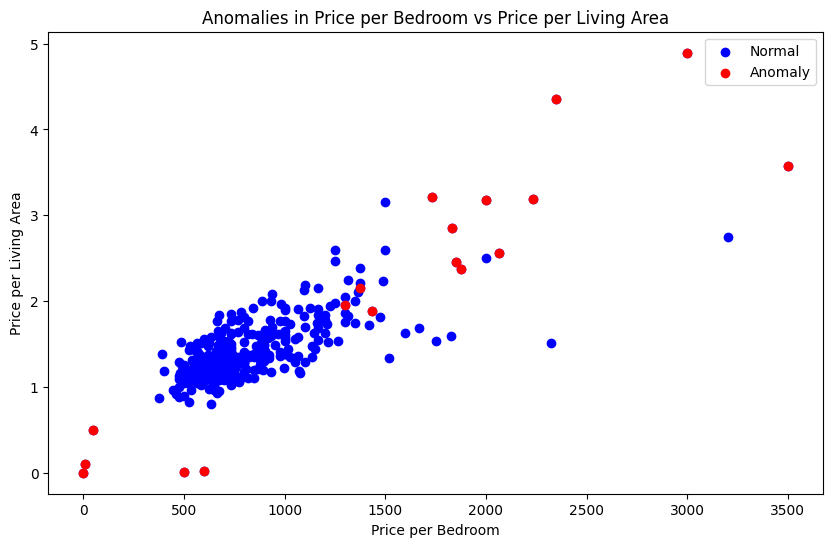

In [16]:
# Scatter plot of 'Price per Bedroom' vs 'Price per Living Area'
plt.figure(figsize=(10, 6))
plt.scatter(final_df['Price per Bedroom'], final_df['Price per Living Area'], c='blue', label='Normal')
plt.scatter(final_df[final_df['is_anomaly'] == 1]['Price per Bedroom'], 
            final_df[final_df['is_anomaly'] == 1]['Price per Living Area'], 
            c='red', label='Anomaly')
plt.xlabel('Price per Bedroom')
plt.ylabel('Price per Living Area')
plt.title('Anomalies in Price per Bedroom vs Price per Living Area')
plt.legend()
plt.show()

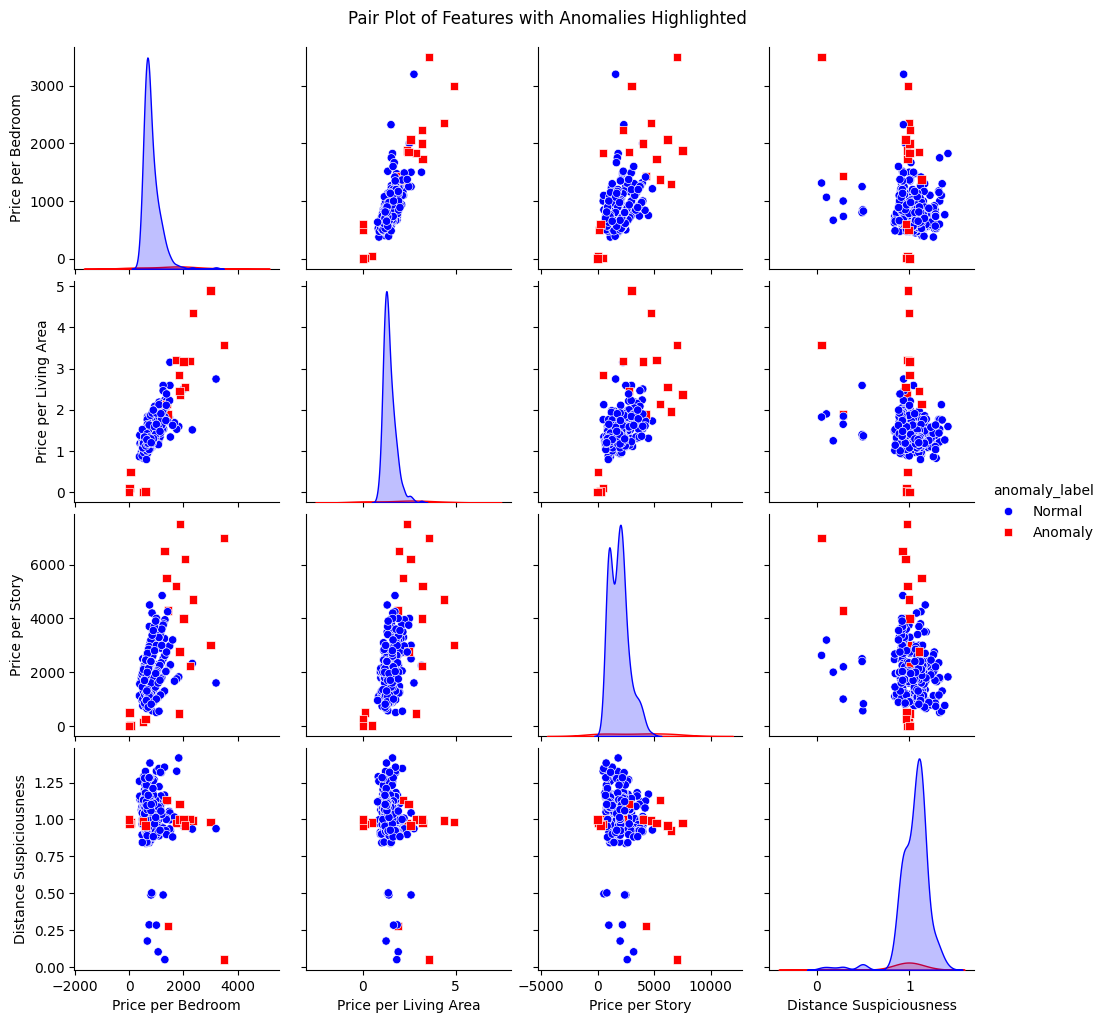

In [17]:
import seaborn as sns

# Add anomaly column as categorical for visualization
final_df['anomaly_label'] = final_df['is_anomaly'].map({1: 'Anomaly', 0: 'Normal'})

# Create a pair plot of key features
sns.pairplot(final_df[['Price per Bedroom', 'Price per Living Area', 'Price per Story', 'Distance Suspiciousness', 'anomaly_label']], 
             hue='anomaly_label', palette={'Normal': 'blue', 'Anomaly': 'red'}, markers=["o", "s"])
plt.suptitle('Pair Plot of Features with Anomalies Highlighted', y=1.02)
plt.show()


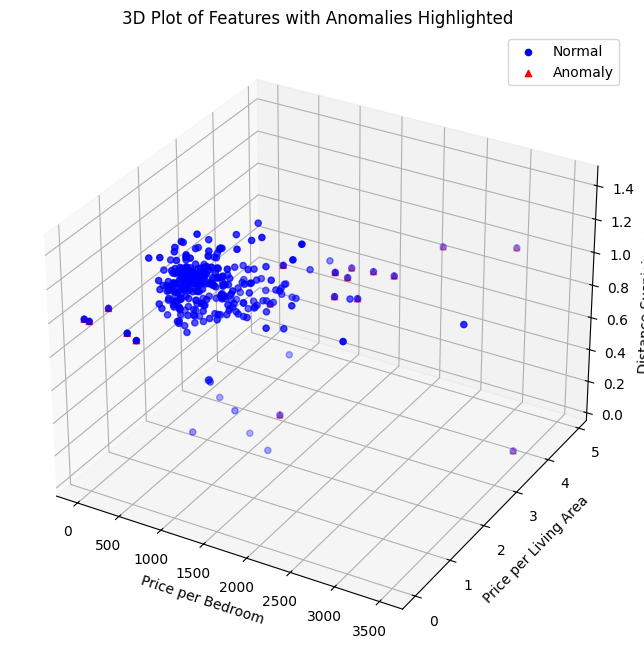

In [18]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter plot of key features with anomalies
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normal points
ax.scatter(final_df['Price per Bedroom'], final_df['Price per Living Area'], final_df['Distance Suspiciousness'], 
           c='blue', marker='o', label='Normal')

# Anomalous points
ax.scatter(final_df[final_df['is_anomaly'] == 1]['Price per Bedroom'], 
           final_df[final_df['is_anomaly'] == 1]['Price per Living Area'], 
           final_df[final_df['is_anomaly'] == 1]['Distance Suspiciousness'], 
           c='red', marker='^', label='Anomaly')

ax.set_xlabel('Price per Bedroom')
ax.set_ylabel('Price per Living Area')
ax.set_zlabel('Distance Suspiciousness')
plt.title('3D Plot of Features with Anomalies Highlighted')
plt.legend()
plt.show()


In [19]:
from sklearn.cluster import DBSCAN


# Step 1: Standardize the features in your dataset
scaler = StandardScaler()
X = final_df[['Price per Bedroom', 'Price per Full Bathroom', 'Price per Total Bathroom',
              'Price per Story', 'Price per Garage Space', 'Price per Living Area',
              'Price per Lot Size Acre', 'Price per Year Built', 'Under_30_Days_Flag',
              'Distance Suspiciousness', 'is_phone_suspicious', 'contains_suspicious_diction']]

X_scaled = scaler.fit_transform(X)

# Step 2: Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your data
dbscan_labels = dbscan.fit_predict(X_scaled)

# Step 3: Add the DBSCAN labels to the DataFrame
# DBSCAN assigns -1 to anomalies, 0 or positive integers to clusters
final_df['dbscan_anomaly'] = np.where(dbscan_labels == -1, 1, 0)

# Step 4: Display the rows that are flagged as anomalies by DBSCAN
dbscan_anomalies = final_df[final_df['dbscan_anomaly'] == 1]
print(dbscan_anomalies)

# Optionally, save the anomalies detected by DBSCAN to a file
dbscan_anomalies.to_csv('data/dbscan_anomalies.csv', index=False)


                                           List Number  Price per Bedroom  \
0    gAAAAABm9wKy8iEF2iPj4yUG9W9aJzlue0ha1rOr4yH2hV...              847.5   
1    gAAAAABm9wKyZy5yVqVfOab8ncZ2KX9fPYOjfO9KuSTwOh...              540.0   
2    gAAAAABm9wKyO0FKSTfQtXpJt527HRb4FRUbo6r7zsshdH...              500.0   
3    gAAAAABm9wKyzMbRTpX1vRA4eWcmaYrxsjpy9YlV1jQyBf...             1475.0   
4    gAAAAABm9wKyN72eWI3levdaCpsUo_0YQoDg888YszAwJH...             1500.0   
..                                                 ...                ...   
340                                 ScamListing_123456              500.0   
341                                 ScamListing_123457               50.0   
342                                 ScamListing_123458               10.0   
343                                 ScamListing_123459              600.0   
344                                 ScamListing_123460                0.0   

     Price per Full Bathroom  Price per Total Bathroom  Price per Story  \
